In [1]:
### 1 Generazione delle etichette nel main dataset

In [14]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Leggi il dataset etichettato
labeled_file_path = 'Dataset/labeled_dataset.csv'
labeled_df = pd.read_csv(labeled_file_path, delimiter=';')

# Leggi il dataset non etichettato
unlabeled_file_path = 'Dataset/main_dataset.csv'
unlabeled_df = pd.read_csv(unlabeled_file_path, delimiter=',')

# Estrai le caratteristiche e le etichette dal dataset etichettato
features_labeled = labeled_df.drop(columns=['target'])
labels_labeled = labeled_df['target']

# Estrai le caratteristiche dal dataset non etichettato
features_unlabeled = unlabeled_df  # Considerando che le etichette verranno predette

# Vettorizza le caratteristiche usando TF-IDF
vectorizer = TfidfVectorizer()
X_labeled = vectorizer.fit_transform(features_labeled.apply(lambda x: ' '.join(x.astype(str)), axis=1))
X_unlabeled = vectorizer.transform(features_unlabeled.apply(lambda x: ' '.join(x.astype(str)), axis=1))

# Calcola la similarità coseno tra tutte le coppie di applets
similarity_matrix = cosine_similarity(X_unlabeled, X_labeled)

# Imposta una soglia di similarità
similarity_threshold = 0.2721288492271225

# Predici le etichette per le applets nel dataset non etichettato
y_pred = []
for i in range(len(unlabeled_df)):
    max_similarity = max(similarity_matrix[i])
    if max_similarity >= similarity_threshold:
        idx = list(similarity_matrix[i]).index(max_similarity)
        predicted_label = labels_labeled[idx]  # Usa l'etichetta dal dataset etichettato
    else:
        predicted_label = 0  # Etichetta innocua
    
    y_pred.append(predicted_label)

# Aggiungi le predizioni al dataset non etichettato come colonna 'target'
unlabeled_df['target'] = y_pred

# Salva il dataset con le nuove etichette
unlabeled_df.to_csv('Dataset/labeled_main_dataset.csv', index=False)


In [ ]:
### 1.1 Calcolo del threshold

In [17]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Inizializza un array per le massime similarità
max_sim = np.zeros(X_unlabeled.shape[0])  # Numero di righe di X_unlabeled

# Calcola la massima similarità per ogni riga della matrice di similarità
for i in range(X_unlabeled.shape[0]):
    max_sim[i] = np.max(similarity_matrix[i])

# Calcola il valore medio delle massime similarità
mean_max_similarity = np.mean(max_sim)

print(f"Valore medio delle massime similarità: {mean_max_similarity}")


NameError: name 'X_unlabeled' is not defined

In [ ]:
### 1.2 analisi del dataset appena etichettato

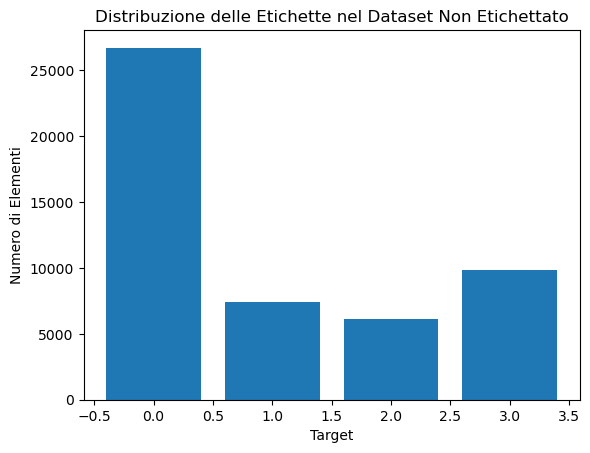

In [16]:
import matplotlib.pyplot as plt

# Assicurati che 'target' sia convertito in numerico se necessario
unlabeled_df['target'] = pd.to_numeric(unlabeled_df['target'], errors='coerce')

# Rimuovi le righe con valori non validi, se presenti
unlabeled_df = unlabeled_df.dropna(subset=['target'])

# Ora calcola il conteggio delle etichette
labels = unlabeled_df['target'].values
unique, counts = np.unique(labels, return_counts=True)

# Crea il grafico a barre
plt.bar(unique, counts)
plt.xlabel('Target')
plt.ylabel('Numero di Elementi')
plt.title('Distribuzione delle Etichette nel Dataset Non Etichettato')
plt.show()


In [ ]:
## 2 Analisi del main dataset

In [ ]:
###2.1 eliminazione delle colonne con potenza predittiva nulla

In [18]:
import pandas as pd

columns_to_drop = ['id','Unnamed: 0']

# Leggi il dataset etichettato
labeled_file_path = 'Dataset/labeled_main_dataset.csv'
unlabeled_df = pd.read_csv(labeled_file_path, delimiter=',')

# Crea una copia del DataFrame escludendo le colonne specificate
unlabeled_df_cleaned = unlabeled_df.drop(columns=columns_to_drop, errors='ignore')

# Stampare solo l'elenco delle colonne rimaste nel DataFrame
print(unlabeled_df_cleaned.columns)

Index(['by_service_owner', 'channels', 'description', 'friendly_id', 'id.1',
       'installs_count', 'name', 'permissions', 'pro_features',
       'requires_android_app', 'requires_ios_app', 'requires_mobile_app',
       'service_names', 'service_slug', 'services', 'speed',
       'uniq_permissions', 'services_len', 'service_triggers',
       'service_actions', 'triggers_category', 'actions_category', 'target'],
      dtype='object')


In [ ]:
## 2.2 eliminazione applets con valori nulli o NaN

In [19]:
unlabeled_df_cleaned = unlabeled_df_cleaned.dropna()

# Supponendo che unlabeled_df_cleaned sia il tuo DataFrame pulito
num_null_rows = unlabeled_df_cleaned.isnull().sum(axis=1).sum()

# Stampa il numero di righe con valori nulli o NaN
print(f"Numero di righe con valori nulli o NaN: {num_null_rows}")

Numero di righe con valori nulli o NaN: 0


In [ ]:
## 2.3 tencica dell'undersampling per la classe 0

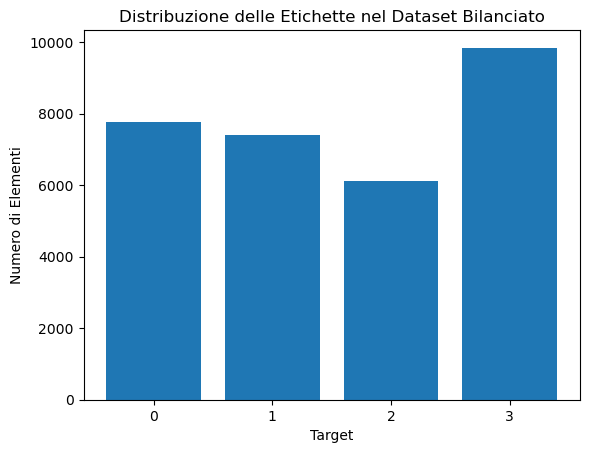

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Supponiamo che 'unlabeled_df_cleaned' sia il tuo DataFrame e 'target' la colonna delle etichette
# unlabeled_df_cleaned = pd.read_csv('path_to_your_data.csv')  # Carica il tuo dataset se necessario

# Dividere i dati per classe
df_class_0 = unlabeled_df_cleaned[unlabeled_df_cleaned['target'] == 0]
df_class_1 = unlabeled_df_cleaned[unlabeled_df_cleaned['target'] == 1]
df_class_2 = unlabeled_df_cleaned[unlabeled_df_cleaned['target'] == 2]
df_class_3 = unlabeled_df_cleaned[unlabeled_df_cleaned['target'] == 3]

# Calcolare la dimensione media delle classi 1, 2 e 3
n_avg = int((len(df_class_1) + len(df_class_2) + len(df_class_3)) / 3)

# Sotto-campionamento della classe 0
df_class_0_under = resample(df_class_0, 
                            replace=False,    # campionamento senza sostituzione
                            n_samples=n_avg,  # per abbinare la dimensione media delle altre classi
                            random_state=42)  # per la riproducibilità

# Ricomporre il dataset bilanciato
unlabeled_df_cleaned = pd.concat([df_class_0_under, df_class_1, df_class_2, df_class_3])

# Assicurati che 'target' sia convertito in numerico se necessario
unlabeled_df_cleaned['target'] = pd.to_numeric(unlabeled_df_cleaned['target'], errors='coerce')

# Rimuovi le righe con valori non validi, se presenti
unlabeled_df_cleaned = unlabeled_df_cleaned.dropna(subset=['target'])

# Ora calcola il conteggio delle etichette
labels = unlabeled_df_cleaned['target'].values
unique, counts = np.unique(labels, return_counts=True)

# Crea il grafico a barre
plt.bar(unique, counts)
plt.xlabel('Target')
plt.ylabel('Numero di Elementi')
plt.title('Distribuzione delle Etichette nel Dataset Bilanciato')
plt.xticks(unique)  # Aggiungi le etichette degli assi x
plt.show()


In [ ]:
# 3 Addestramento del modello

In [ ]:
#3.1 definizione della classe che definisce i migliori parametri degli algoritmi

In [21]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

class TextClassifier:
    def __init__(self, data, target_column, sample_fraction=0.1, test_size=0.2):
        self.data = data
        self.target_column = target_column
        self.sample_fraction = sample_fraction
        self.test_size = test_size
        self.vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')
        self.best_model = None

    def prepare_data(self):
        X = self.data.drop(columns=[self.target_column])
        y = self.data[self.target_column]

        # Riduci il numero di istanze (campionamento del 10%)
        X_sampled = X.sample(frac=self.sample_fraction, random_state=42)

        # Verifica che gli indici di X_sampled siano presenti in y
        X_sampled_index = X_sampled.index
        y_sampled = y[X_sampled_index]

        # Concatena tutte le colonne in un unico testo per ogni riga
        X_text = X_sampled.apply(lambda row: ' '.join(row.values.astype(str)), axis=1).values

        # Creazione del vettore TF-IDF per le feature testuali
        X_tfidf = self.vectorizer.fit_transform(X_text)
        
        # Utilizza SelectKBest con il test del chi-quadrato per selezionare le migliori caratteristiche
        selector = SelectKBest(score_func=chi2, k=10000)
        X_selected = selector.fit_transform(X_tfidf, y_sampled)

        # Applica la standardizzazione ai dati numerici
        scaler = StandardScaler()
        X_selected_scaled = scaler.fit_transform(X_selected.toarray())  # Converti in array per la standardizzazione

        # Split del dataset in addestramento e test
        X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y_sampled, test_size=self.test_size, random_state=42)

        return X_train, X_test, y_train, y_test

    def train_and_evaluate(self, X_train, y_train, model, param_grid):
        # Usa RandomizedSearchCV per trovare i migliori parametri
        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

        # Esegui la ricerca sui dati di addestramento
        random_search.fit(X_train, y_train)

        # Ottieni i migliori parametri trovati
        best_params = random_search.best_params_
        print("Migliori parametri trovati:", best_params)

        # Usa i migliori parametri per addestrare il modello finale
        best_model = random_search.best_estimator_
        best_model.fit(X_train, y_train)
        self.best_model = best_model  

        return best_model

    def predict(self, X_test):
        if self.best_model is None:
            raise Exception("Il modello non è stato addestrato. Esegui train_and_evaluate() prima di predire.")
        return self.best_model.predict(X_test)

    def evaluate(self, X_test, y_test):
        predictions = self.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='weighted')
        recall = recall_score(y_test, predictions, average='weighted')
        f1 = f1_score(y_test, predictions, average='weighted')
        conf_matrix = confusion_matrix(y_test, predictions)

        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 Score:", f1)
        print("Confusion Matrix:\n", conf_matrix)

In [ ]:
#3.2 Training con diversi algoritmi di classificazione

In [ ]:
#3.2.1 SVM

In [22]:
from sklearn.svm import SVC

# Definisci il modello da utilizzare
svm_model = SVC()

# Definisci la griglia dei parametri
svm_param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Prova sia kernel lineare che RBF
    'C': [0.1, 1, 10, 100],  # Prova diversi valori di C
    'gamma': ['scale', 'auto', 0.1, 1.0],  # Prova diversi valori di gamma
    'degree': [2, 3, 4],  # Solo se si utilizza il kernel 'poly', prova diversi gradi
    'coef0': [0.0, 0.1, 0.5],  # Termine indipendente in kernel polinomiali e sigmoidali
    'shrinking': [True, False],  # Abilita o disabilita l'euristica di restringimento
    'probability': [True, False],  # Abilita o disabilita la stima della probabilità
    'class_weight': [None, 'balanced', {0: 0.8, 1: 1.0, 2: 1.0, 3: 1.2}],  # Pesi delle classi per gestire lo sbilanciamento
    'decision_function_shape': ['ovo', 'ovr'],  # Strategia per la decisione multi-classe
    'random_state': [42],  # Seme casuale per riproducibilità
    'tol': [1e-3, 1e-4],  # Tolleranza per la precisione del criterio di arresto
    'max_iter': [1000, 2000]  # Numero massimo di iterazioni
}

text_classifier = TextClassifier(data=unlabeled_df_cleaned, target_column='target')
X_train, X_test, y_train, y_test = text_classifier.prepare_data()
svm_best_model = text_classifier.train_and_evaluate(X_train, y_train, model=svm_model, param_grid=svm_param_grid)

# Predizioni sul set di test
predictions = text_classifier.predict(X_test)

#Valutazione dei risultati del modello
text_classifier.evaluate(X_test, y_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
3.2.1.1 Training veloce di SVM

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# Assumo che unlabeled_df_cleaned sia il DataFrame contenente i tuoi dati
X = unlabeled_df_cleaned.drop(columns=["target"])
y = unlabeled_df_cleaned["target"]

# Creazione del vettore TF-IDF per le feature testuali con normalizzazione e gestione delle stop words
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')
X_text = X.apply(lambda row: ' '.join(row.values.astype(str)), axis=1).values
X_tfidf = vectorizer.fit_transform(X_text)

# Utilizza SelectKBest con il test del chi-quadrato per selezionare le migliori caratteristiche
selector = SelectKBest(score_func=chi2, k=10000)
X_selected = selector.fit_transform(X_tfidf, y)

# Prepara i dati (X_train, X_test, y_train, y_test) usando train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.1, random_state=42)

# Definizione dei pesi delle classi
class_weights = {0: 0.8, 1: 1.0, 2: 1.0, 3: 1.2}  

# Definisci il modello SVM con i parametri specificati
svm_model = SVC(kernel='rbf', C=10, gamma='scale', degree=2, coef0=0.1,
                shrinking=True, probability=False, class_weight=class_weights,
                decision_function_shape='ovr', random_state=42, tol=0.001, max_iter=10000)

# Addestra il modello SVM
svm_model.fit(X_train, y_train)

# Effettua le predizioni
predictions = svm_model.predict(X_test)

# Valuta le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, predictions)

# Stampare le metriche di valutazione
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9553341902313625
Precision: 0.9552717767515997
Recall: 0.9553341902313625
F1 Score: 0.9552842918577017
Confusion Matrix:
 [[719  19  11  24]
 [ 11 734   7   3]
 [ 21   7 576   5]
 [ 13   5  13 944]]


In [ ]:
#3.2.2 Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Definizione del modello RandomForest
rf_classifier = RandomForestClassifier(random_state=42)

# Definizione della griglia degli iperparametri da esplorare
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Prova diversi numeri di alberi
    'max_depth': [None, 10, 20, 30],  # Prova diverse profondità degli alberi
    'min_samples_split': [2, 5, 10],  # Prova diverse dimensioni minime del nodo
    'min_samples_leaf': [1, 2, 4]  # Prova diverse dimensioni minime delle foglie
}

text_classifier = TextClassifier(data=unlabeled_df_cleaned, target_column='target')
X_train, X_test, y_train, y_test = text_classifier.prepare_data()
text_classifier.train_and_evaluate(X_train, y_train, model=rf_classifier, param_grid=rf_param_grid)

# Predizioni sul set di test
predictions = text_classifier.predict(X_test)

#Valutazione dei risultati del modello
text_classifier.evaluate(X_test, y_test)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Migliori parametri trovati:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Miglior punteggio di validazione cross-validated:
0.8264367816091953
Accuracy: 0.8201284796573876
Precision: 0.8193116041973844
Recall: 0.8201284796573876
F1 Score: 0.8193904201585529
Confusion Matrix:
 [[176  23  12  30]
 [ 18 197  12  11]
 [ 13   6 169   2]
 [ 22   9  10 224]]


In [ ]:
# 3.2.3 XGBoost

In [10]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/a2/48/d5da8591891327b0faf08179d420fba3893c6134bdd449497c5329e4cb01/xgboost-2.1.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 220.2 kB/s eta 0:09:28
   ---------------------------------------- 0.0/124.9 MB 245.8 kB/s eta 0:08:29
   ---------------------------------------- 0.1/124.9 MB 547.6 kB/s eta 0:03:48
   ---------------------------------------- 0.2/124.9 MB 704.6 kB/s eta 0:02:58
   ---------------------------------------- 0.2/124.9 MB 765.3 kB/s eta 0:02:43
   ---------------------------------------- 0.3/124.9 MB 853.3 kB/s eta 0:02:27
   ---------------------------------------- 0.3/124.9 MB 873.8 kB/s eta 0:02:23
   -------------------

In [12]:
from xgboost import XGBClassifier

# Definizione del modello XGBoost
xgb_classifier = XGBClassifier(random_state=42)

# Definizione della griglia degli iperparametri da esplorare
xgb_param_grid = {
    'n_estimators': [50, 100, 200],  # Prova diversi numeri di alberi
    'max_depth': [3, 6, 9],  # Prova diverse profondità degli alberi
    'learning_rate': [0.01, 0.1, 0.3]  # Prova diversi tassi di apprendimento
}

text_classifier = TextClassifier(data=unlabeled_df_cleaned, target_column='target')
X_train, X_test, y_train, y_test = text_classifier.prepare_data()
text_classifier.train_and_evaluate(X_train, y_train, model=xgb_classifier, param_grid=xgb_param_grid)

# Predizioni sul set di test
predictions = text_classifier.predict(X_test)

#Valutazione dei risultati del modello
text_classifier.evaluate(X_test, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Migliori parametri trovati:
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
Miglior punteggio di validazione cross-validated:
0.8691300221448909
Accuracy: 0.8490364025695931
Precision: 0.849039784522074
Recall: 0.8490364025695931
F1 Score: 0.8488219249152099
Confusion Matrix:
 [[193  18  14  16]
 [ 16 198  10  14]
 [  9  10 170   1]
 [ 18   7   8 232]]


In [ ]:
# 3.2.4 KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Definizione del modello KNN
knn_classifier = KNeighborsClassifier()

# Definizione della griglia degli iperparametri da esplorare
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Prova diversi valori di k
    'weights': ['uniform', 'distance'],  # Prova pesi uniformi e basati sulla distanza
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Diverse metriche di distanza
}

text_classifier = TextClassifier(data=unlabeled_df_cleaned, target_column='target')
X_train, X_test, y_train, y_test = text_classifier.prepare_data()
text_classifier.train_and_evaluate(X_train, y_train, model=knn_classifier, param_grid=knn_param_grid)

# Predizioni sul set di test
predictions = text_classifier.predict(X_test)

#Valutazione dei risultati del modello
text_classifier.evaluate(X_test, y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Migliori parametri trovati:
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Miglior punteggio di validazione cross-validated:
0.7970452388484657
Accuracy: 0.7708779443254818
Precision: 0.7732918208872924
Recall: 0.7708779443254818
F1 Score: 0.7688977682508319
Confusion Matrix:
 [[150  19  26  46]
 [ 17 193  13  15]
 [ 16   6 159   9]
 [ 14  10  23 218]]


In [ ]:
#3.3 Algoritmi di regressione

In [ ]:
#3.3.1 Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

# Definisci il modello da utilizzare
logistic_regression_model = LogisticRegression()

# Definisci la griglia dei parametri
logistic_regression_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Tipi di penalizzazioni
    'C': [0.01, 0.1, 1, 10, 100],  # Valori di C per la regolarizzazione
    'solver': ['liblinear', 'saga'],  # Solver da utilizzare
    'max_iter': [100, 200, 300]  # Numero massimo di iterazioni
}

text_classifier = TextClassifier(data=unlabeled_df_cleaned, target_column='target')
X_train, X_test, y_train, y_test = text_classifier.prepare_data()
text_classifier.train_and_evaluate(X_train, y_train, model=logistic_regression_model, param_grid=logistic_regression_param_grid)

# Predizioni sul set di test
predictions = text_classifier.predict(X_test)

# Valutazione dei risultati del modello
text_classifier.evaluate(X_test, y_test)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
225 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    solver = _check_solv

Migliori parametri trovati:
{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Miglior punteggio di validazione cross-validated:
0.8668417167563007
Accuracy: 0.8640256959314775
Precision: 0.864375210582075
Recall: 0.8640256959314775
F1 Score: 0.863713026734842
Confusion Matrix:
 [[195  17   9  20]
 [ 14 202  13   9]
 [ 10   5 174   1]
 [ 13   5  11 236]]


In [ ]:
#3.3.1.1 Valutazione veloce del modello

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# Assumo che unlabeled_df_cleaned sia il DataFrame contenente i tuoi dati
X = unlabeled_df_cleaned.drop(columns=["target"])
y = unlabeled_df_cleaned["target"]

# Creazione del vettore TF-IDF per le feature testuali con normalizzazione e gestione delle stop words
vectorizer = TfidfVectorizer(ngram_range=(1, 2), lowercase=True, stop_words='english')
X_text = X.apply(lambda row: ' '.join(row.values.astype(str)), axis=1).values
X_tfidf = vectorizer.fit_transform(X_text)

# Utilizza SelectKBest con il test del chi-quadrato per selezionare le migliori caratteristiche
selector = SelectKBest(score_func=chi2, k=10000)
X_selected = selector.fit_transform(X_tfidf, y)

# Prepara i dati (X_train, X_test, y_train, y_test) usando train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Definizione dei pesi delle classi
class_weights = {0: 0.8, 1: 1.0, 2: 1.0, 3: 1.2}  

# Definisci il modello di Regressione Logistica con i parametri specificati
logistic_model = LogisticRegression(penalty='l1', C=10, solver='liblinear', max_iter=100, class_weight=class_weights, random_state=42)

# Addestra il modello di Regressione Logistica
logistic_model.fit(X_train, y_train)

# Effettua le predizioni
predictions = logistic_model.predict(X_test)

# Valuta le prestazioni del modello
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')
conf_matrix = confusion_matrix(y_test, predictions)

# Stampare le metriche di valutazione
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.943926735218509
Precision: 0.9437966026597965
Recall: 0.943926735218509
F1 Score: 0.9437784858196091
Confusion Matrix:
 [[1381   50   37   64]
 [  37 1439    9   15]
 [  29   16 1162   17]
 [  35   15   25 1893]]


In [ ]:
#4 Estrazione del modello

In [27]:
from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

#Addestramento del modello con tutte le tuple
svm_model.fit(X_selected, y)

# Creazione del PMMLPipeline con il modello già addestrato
pipeline = PMMLPipeline([("Classification", svm_model)])
#estrazione pipiline in file .pmml
sklearn2pmml(pipeline, "ClassificatoreSicurezzaApplets.pmml", with_repr = True)